Install tensorflow ver 2.x before running this

In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

In [1]:
import numpy as np
import pandas as pd
import ccm_coda

# Sampling functions, etc.
from tools import *

import pickle, time
import warnings
warnings.filterwarnings('ignore')

# Experiment with fixed n, p, and effect size
$n=200,\ p=100,\ e = \log{5}$. Only the generating seed changes through the experiments

In [5]:
n = 200
dim = 100
diff_ratio = 0.1  # 10 taxa incorporate true signals
b = np.log(5)

# Zero ratio
zero_ratios = np.zeros(50)
for i in range(50):
    X, diff = Sampling(n, dim, diff_ratio=diff_ratio, b=b, seed=7*i)
    zero_ratios[i] = np.sum(np.sum(X==0)) / X.size
np.mean(zero_ratios), np.std(zero_ratios)

(0.4999739841269841, 0.03314152862722943)

$\epsilon = 10^{-3}$ is proposed for binary responses.  
Learning rates were manually chosen to achieve convergence of gradient descent

In [ ]:
epsilon = 1e-3
type_Y = 'binary'
iterations = 2000

# label representing the existence of the signal
Y = np.r_[(-1) * np.ones(n // 2), np.ones(n // 2)]  

num_true_pos = list()
for i in range(50):
    seed = 7 * i
    true_pos_per_numfeat = list()

    X, diff = Sampling(n, dim, diff_ratio=diff_ratio, b=b, seed=seed)
    true = np.sort(diff)
    
    # Make X compositional
    X = X / np.sum(X, axis=1)[:, None]

    for num_features in range(5, round(dim * 0.41), 5):
        print("{}th iteration, selecting {} variables".format(i, num_features))
        # learning rate is chosen to achieve convergence
        lr = epsilon * 0.03 * num_features
        rank, w = ccm_coda.ccm(X, Y, num_features, type_Y, epsilon, learning_rate=lr, 
                               iterations=iterations, init=None, verbose=False)
        selected_feats = np.array(X.columns[np.sort(np.argsort(rank)[:num_features])])
        print("Weights on the selected features:", w[np.sort(np.argsort(rank)[:num_features])])
        true_pos = summary_of_discovery(selected_feats, true)
        true_pos_per_numfeat.append(true_pos)
    num_true_pos.append(true_pos_per_numfeat)
    
    with open("./results/Synthetic_final/200_100_log5_eps_1e-3.pickle", 'wb') as f:
        pickle.dump(num_true_pos, f)

In [6]:
with open("./results/Synthetic_final/200_100_log5_eps_1e-3.pickle", 'rb') as fi:
    res = pickle.load(fi)
print(np.array(res).mean(0))
print(np.array(res).std(0) / np.sqrt(50))

[4.22 7.06 8.2  8.68 8.98 9.32 9.4  9.44]
[0.1882339  0.22522877 0.22627417 0.17762883 0.22713872 0.2217025
 0.22090722 0.22119675]


## (Optional) Applying just Euclidean method
Check also for Euclidean method for comparison; $\epsilon = 10^{-3}$ is used as proposed in Chen et al. (2017).  
Source code: ccm.py of https://github.com/Jianbo-Lab/CCM

In [ ]:
# Using Euclidean method
import ccm 

epsilon = 1e-3
Y = np.r_[(-1) * np.ones(n // 2), np.ones(n // 2)] 
type_Y = 'binary'
iterations = 2000

num_true_pos = list()

for i in range(50):
    seed = 7 * i
    true_pos_per_numfeat = list()

    X, diff = Sampling(n, dim, diff_ratio=diff_ratio, b=b, seed=seed)
    true = np.sort(diff)
    X = X / np.sum(X, axis=1)[:, None]

    for num_features in range(5, round(dim * 0.41), 5):
        print("{}th iteration, selecting {} variables".format(i, num_features))
        lr = epsilon * 0.02 * num_features
        rank, w = ccm.ccm(X, Y, num_features, type_Y, epsilon, learning_rate=lr, 
                          iterations=iterations, verbose=False)
        selected_feats = np.array(X.columns[np.sort(np.argsort(rank)[:num_features])])
        print("Weights on the selected features:", w[np.sort(np.argsort(rank)[:num_features])])
        true_pos = summary_of_discovery(selected_feats, true)
        true_pos_per_numfeat.append(true_pos)
    num_true_pos.append(true_pos_per_numfeat)
    
    with open("./results/Synthetic_final/num_true_pos_200_100_log5_eucd_efixed_1e-3.pickle", 'wb') as f:
        pickle.dump(num_true_pos, f)

In [10]:
with open("./results/Synthetic_final/num_true_pos_200_100_log5_eucd_efixed_1e-3.pickle", 'rb') as fi:
    load_efix3 = pickle.load(fi)
print(np.array(load_efix3).mean(0))

[4.08 5.28 6.2  7.16 7.78 8.42 8.94 9.4 ]


Inferior result than compositional algorithm (somehow comparable when m is large enough than the true value 10, but this is natural)

## Plot the results

In [2]:
import pyreadr
import matplotlib.pyplot as plt

In [5]:
with open("./results/Synthetic_final/200_100_log5_eps_1e-3.pickle", 'rb') as fi:
    proposed = np.array(pickle.load(fi))
    
coda_lasso = pyreadr.read_r("./LassoSelbal/results/Synthetic_data/Truepos_lasso_0.5rep.RData")
selbal = pyreadr.read_r("./LassoSelbal/results/Synthetic_data/Truepos_selbal_0.5rep.RData")

coda_lasso = np.array(coda_lasso['num_true_pos'])
selbal = np.array(selbal['truepos_selbal'])

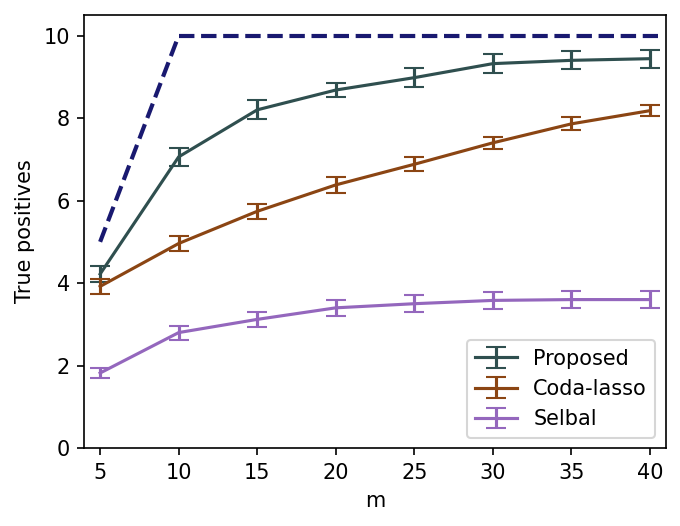

In [6]:
plt.figure(figsize=(5, 3.75), dpi=150)

plt.hlines(10, 10, 40.5, colors="midnightblue", linestyles="--", linewidths=2)
plt.plot([5, 10], [5, 10], color="midnightblue", linestyle="--", linewidth=2)

plt.errorbar([5 * i for i in range(1, 9)], proposed.mean(0), 
             yerr=proposed.std(0)/np.sqrt(50), capsize=5,
             c='darkslategrey', label="Proposed")
plt.errorbar([5 * i for i in range(1, 9)], coda_lasso.mean(0), 
             yerr=coda_lasso.std(0)/np.sqrt(50), capsize=5,
             c='saddlebrown', label="Coda-lasso")
plt.errorbar([5 * i for i in range(1, 9)], selbal.mean(0), 
             yerr=selbal.std(0)/np.sqrt(50), capsize=5,
             c='tab:purple', label="Selbal")

plt.xticks([5 * i for i in range(1, 9)])
plt.xlim(4, 41)
plt.ylim(0, 10.5)

plt.xlabel('m')
plt.ylabel('True positives')

plt.legend()

plt.savefig('./results/Synthetic_mvary_final', dpi=300)
plt.show()

#  Experiment with varying sample size $n$

$n = 200, 400, ..., 1000$

In [25]:
num_features = 10
dim = 100
diff_ratio = 0.1  # 10 taxa incorporates true signals
b = np.log(5)

type_Y = 'binary'
epsilon = 0.001
iterations = 3000

lr = 0.0003

In [ ]:
repetition = list()
for i in range(50):
    print(i, 'th iteration')
    num_true_pos = list()
    st = time.time()
    for n in [200, 400, 600, 800, 1000]:
        print("n =", n)
        Y = np.r_[(-1) * np.ones(n // 2), np.ones(n // 2)]
        X, diff = Sampling(n, dim, diff_ratio=diff_ratio, b=b, seed=7 * i)
        true = np.sort(diff)

        X = X / np.sum(X, axis=1)[:, None]
        rank, w = ccm_coda.ccm(X, Y, num_features, type_Y, epsilon, learning_rate=lr, 
                                   iterations=iterations, init=None, verbose=False)
        selected_feats = np.array(X.columns[np.sort(np.argsort(rank)[:num_features])])
        print("Weights on the selected features:", w[np.sort(np.argsort(rank)[:num_features])])
        true_pos = summary_of_discovery(selected_feats, true)
        num_true_pos.append(true_pos)
    repetition.append(num_true_pos)
    print(time.time() - st, "sec per one experiment")

    with open("./results/Synthetic_final/varying_n.pickle", 'wb') as f:
        pickle.dump(repetition, f)

np.mean(repetition, 0), np.std(repetition, 0)

In [29]:
with open("./results/Synthetic_final/varying_n.pickle", 'rb') as fi:
    repetition2 = pickle.load(fi)
np.mean(repetition2, 0), np.std(repetition2, 0)/np.sqrt(50), np.array(repetition2).shape

(array([7.06, 8.34, 9.12, 9.5 , 9.5 ]),
 array([0.22522877, 0.26923596, 0.18469434, 0.11045361, 0.08124038]),
 (50, 5))

### Plot the results

In [7]:
with open("./results/Synthetic_final/varying_n.pickle", 'rb') as fi:
    repetition = pickle.load(fi)
    
coda_lasso = pyreadr.read_r("./LassoSelbal/results/Synthetic_data/Truepos_nvary_lasso_0.5rep.RData")
selbal = pyreadr.read_r("./LassoSelbal/results/Synthetic_data/Truepos_nvary_selbal_0.5rep.RData")

coda_lasso = np.array(coda_lasso['num_true_pos'])
selbal = np.array(selbal['truepos_selbal_nvary'])

repetition = np.array(repetition)

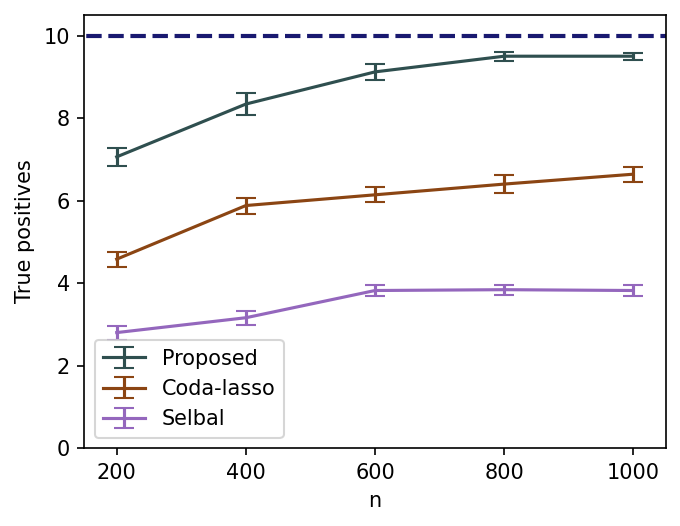

In [9]:
plt.figure(figsize=(5, 3.75), dpi=150)

plt.hlines(10, 50, 1050, colors="midnightblue", linestyles="--", linewidths=2)
plt.errorbar([200 * i for i in range(1, 6)], repetition.mean(0), 
             yerr=repetition.std(0)/np.sqrt(50), capsize=5,
             c='darkslategrey', label="Proposed")
plt.errorbar([200 * i for i in range(1, 6)], coda_lasso.mean(0), 
             yerr=coda_lasso.std(0)/np.sqrt(50), capsize=5,
             c='saddlebrown', label="Coda-lasso")
plt.errorbar([200 * i for i in range(1, 6)], selbal.mean(0), 
             yerr=selbal.std(0)/np.sqrt(50), capsize=5,
             c='tab:purple', label="Selbal")

plt.xticks([200 * i for i in range(1, 6)])
plt.xlim(150, 1050)
plt.ylim(0, 10.5)

plt.xlabel('n')
plt.ylabel('True positives')

plt.legend()

plt.savefig('./results/Synthetic_nvary_final')
plt.show()

# With different zero ratio
Obtain this by adjusting mean_a and mean_t
- 70%: (a, t) = (-1.1 , -0.5)
- 50%: ours, (0,0)
- 30%: (1, 0.5)
- 10%: (2.2, 1.5)

In [5]:
zero_ratio = {10: {"mean_a":2.2, "mean_t": 1.5},
                30: {"mean_a":1., "mean_t": 0.5},
                50: {"mean_a":0., "mean_t": 0.},
                70: {"mean_a":-1.1, "mean_t": -0.5}
                }

n = 500
dim = 100
diff_ratio = 0.1
b = np.log(5)

In [17]:
# Check zero ratios
for n in [200, 400, 600]:
    for ratio in [10, 30, 50, 70]:
        zero_ratios = np.zeros(50)
        for i in range(50):
            X, diff = Sampling(n, dim, diff_ratio=diff_ratio, b=b, seed=7*i, **zero_ratio[ratio])
            zero_ratios[i] = np.sum(np.sum(X==0)) / X.size
            if not np.isin(diff, X.columns).all():
                print(i)
        print("n = {}, aims {}%:".format(n, ratio), np.mean(zero_ratios), np.std(zero_ratios))

n = 200, aims 10%: 0.10095699999999999 0.016095238457382356
n = 200, aims 30%: 0.30264804040404036 0.029268170138622276
n = 200, aims 50%: 0.4999739841269841 0.03314152862722943
n = 200, aims 70%: 0.7021890988708046 0.030347706909419108
n = 400, aims 10%: 0.09868199999999999 0.013394736876848308
n = 400, aims 30%: 0.301464 0.025230930006640655
n = 400, aims 50%: 0.5014096559472274 0.029623154792838845
n = 400, aims 70%: 0.710164289544018 0.026975890951143396
n = 600, aims 10%: 0.09954166666666668 0.015893145010769057
n = 600, aims 30%: 0.30302599999999996 0.02949606963647869
n = 600, aims 50%: 0.5031504781144781 0.033638455511561825
n = 600, aims 70%: 0.7098719006434615 0.030439311882720692


Fix n = 500, p = 10, and m = 10

In [6]:
n = 500
num_features = 10
dim = 100
diff_ratio = 0.1  # 10 taxa incorporates true signals
b = np.log(5)

type_Y = 'binary'
epsilon = 0.001
iterations = 3000

lr = 0.0002

In [ ]:
repetition = list()
Y = np.r_[(-1) * np.ones(n // 2), np.ones(n // 2)]

for i in range(50):
    print(i, 'th iteration...')
    num_true_pos = list()
    st = time.time()
    for ratio in [10, 30, 50, 70]:
        X, true = Sampling(n, dim, diff_ratio=diff_ratio, b=b, seed=7 * i, **zero_ratio[ratio])
        X = X / np.sum(X, axis=1)[:, None]

        rank, w = ccm_coda.ccm(X, Y, num_features, type_Y, epsilon, learning_rate=lr, 
                                   iterations=iterations, init=None, verbose=True)
        selected_feats = np.array(X.columns[np.sort(np.argsort(rank)[:num_features])])
        print("Weights on the selected features:", w[np.sort(np.argsort(rank)[:num_features])])
        true_pos = summary_of_discovery(selected_feats, true)
        num_true_pos.append(true_pos)
    repetition.append(num_true_pos)
    print(time.time() - st, "sec per one experiment")

    with open("./results/Synthetic_safe/varying_zero_ratio_n500_m10.pickle", 'wb') as f:
        pickle.dump(repetition, f)

In [26]:
# n=500
np.mean(repetition, 0), np.std(repetition, 0), np.array(repetition).shape

(array([9.26, 9.1 , 9.12, 8.46]),
 array([1.30858702, 1.45945195, 0.7909488 , 1.32981202]),
 (50, 4))

#### Results

In [10]:
with open("./results/Synthetic_safe/varying_zero_ratio_n500_m10.pickle", 'rb') as fi:
    proposed = pickle.load(fi)

coda_lasso = pyreadr.read_r("./LassoSelbal/results/Synthetic_data/Truepos_diffzero_lasso_0.5rep.RData")
selbal = pyreadr.read_r("./LassoSelbal/results/Synthetic_data/Truepos_zerovary_selbal_0.5rep.RData")

coda_lasso = np.array(coda_lasso['num_true_pos'])
selbal = np.array(selbal['truepos_selbal_zerovary'])

proposed = np.array(proposed)

In [11]:
print(proposed.mean(0), "+/-", proposed.std(0)/np.sqrt(50))
print(coda_lasso.mean(0), "+/-", coda_lasso.std(0)/np.sqrt(50))
print(selbal.mean(0), "+/-", selbal.std(0)/np.sqrt(50))

[9.26 9.1  9.12 8.46] +/- [0.18506215 0.20639767 0.11185705 0.18806382]
[2.32 3.7  5.76 6.3 ] +/- [0.2217025  0.17720045 0.20111688 0.19235384]
[0.78 1.74 3.36 4.22] +/- [0.1305067  0.15181568 0.15686937 0.16802381]


### (Optional) Apply our method to zero-replaced data (10%, 30%, 50%, 70%)

**0.5min replacement**

In [ ]:
repetition = list()
Y = np.r_[(-1) * np.ones(n // 2), np.ones(n // 2)]

for i in range(50):
    print(i, 'th iteration...')
    num_true_pos = list()
    st = time.time()
    for ratio in [10, 30, 50, 70]:
        X, true = Sampling(n, dim, diff_ratio=diff_ratio, b=b, seed=7 * i, safe=0.3, **zero_ratio[ratio])
        columns = X.columns
        X = pd.DataFrame(zero_replacement(np.array(X), 'min', val=0.5))
        X.columns = columns

        rank, w = ccm_coda.ccm(X, Y, num_features, type_Y, epsilon, learning_rate=lr, 
                                   iterations=iterations, init=None, verbose=True)
        selected_feats = np.array(X.columns[np.sort(np.argsort(rank)[:num_features])])
        print("Weights on the selected features:", w[np.sort(np.argsort(rank)[:num_features])])
        true_pos = summary_of_discovery(selected_feats, true)
        num_true_pos.append(true_pos)
    repetition.append(num_true_pos)
    print(time.time() - st, "sec per one experiment")

    with open("./results/Synthetic_safe/varying_zero_ratio_n500_m10_replaced.pickle", 'wb') as f:
        pickle.dump(repetition, f)

In [8]:
np.mean(repetition, 0), np.std(repetition, 0), np.array(repetition).shape

(array([9.28, 9.1 , 9.14, 9.08]),
 array([1.31209756, 1.45945195, 0.84876381, 0.99679486]),
 (50, 4))

**1sum replacement**

In [ ]:
repetition = list()
Y = np.r_[(-1) * np.ones(n // 2), np.ones(n // 2)]

for i in range(50):
    print(i, 'th iteration...')
    num_true_pos = list()
    st = time.time()
    for ratio in [10, 30, 50, 70]:
        X, true = Sampling(n, dim, diff_ratio=diff_ratio, b=b, seed=7 * i, safe=0.3, **zero_ratio[ratio])
        X = X + 1
        X = X / np.sum(X, axis=1)[:, None]

        rank, w = ccm_coda.ccm(X, Y, num_features, type_Y, epsilon, learning_rate=lr, 
                                   iterations=iterations, init=None, verbose=True)
        selected_feats = np.array(X.columns[np.sort(np.argsort(rank)[:num_features])])
        print("Weights on the selected features:", w[np.sort(np.argsort(rank)[:num_features])])
        true_pos = summary_of_discovery(selected_feats, true)
        num_true_pos.append(true_pos)
    repetition.append(num_true_pos)
    print(time.time() - st, "sec per one experiment")

    with open("./results/Synthetic_safe/varying_zero_ratio_n500_m10_1sum_replaced.pickle", 'wb') as f:
        pickle.dump(repetition, f)

In [16]:
np.mean(repetition, 0), np.std(repetition, 0), np.array(repetition).shape

(array([9.28, 9.18, 9.32, 9.02]),
 array([1.31209756, 1.43791516, 0.67646138, 0.96932967]),
 (50, 4))